# Satellite attitude control using reinforcement learning

The following is a report for the project in AE 598- reinforcement learning course. The code developed tried to realize a control algorithm through Reinforcement learning that is robust to system parameters (mass and moment of inertia).

The report is broken into the following sections:
- The environment is simulated using a traditional controller known as the Quaternion Rate feedback. This is used as a baseline for the 
- The environment is then used to train a RL agent using the PPO algorithm that was implemented in homework 6 (my own code and the example code provided by the instructors)
- The same task is repeted with "Stable Baselines" which is a fork off OpenAI's Baselines


This report has run each algorithm run for 200 episodes.

## Basic QRF controller (with Mujoco Environment)

The following section solves the probem using a simple Quaternion Rate Feedback (QRF) controller for one set of inertia and mass.


In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import animation, rc

from IPython.display import HTML
%matplotlib inline

In [2]:
import sat_mujocoenv
import PPO_par as ppo


In [3]:
#Parameters
horizon = 1500 #steps
maxabs_torque=2.50e-3
dt = 5
target_state = np.array([1,0,0,0,0,0,0]) # [q_0,q_1,q_2,q_3,w_0,w_1,w_2]
w_mag = 4e-2
w_tumble = 4e-1
Noise = None
render = False

In [4]:
env = sat_mujocoenv.Sat_mujocoEnv(horizon,maxabs_torque,dt,target_state, w_mag ,w_tumble, Noise,render)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
T = horizon
env.reset()
s = np.zeros((T, env.observation_dim))
r = np.zeros(T)
a = np.zeros((T, env.action_dim))
a_actual = np.zeros((T, env.action_dim))
time = np.zeros(T)
s[0,:] = env.x
for t in range(1,T):
    a[t] =-10e-2*(s[t-1,1:4]-target_state[1:4])-10*(s[t-1,4:]--target_state[4:])
    s[t,:], r[t], _ , _= env.step(a[t])
    a_actual[t] = env.a
    time[t] = env.t

average reward per step = 5.420795825019783


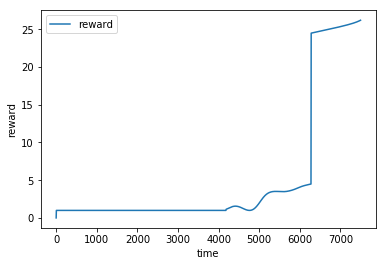

In [6]:
plt.plot(time,r, label='reward')
plt.xlabel('time')
plt.ylabel('reward')
plt.legend()
print(f'average reward per step = {np.mean(r)}')

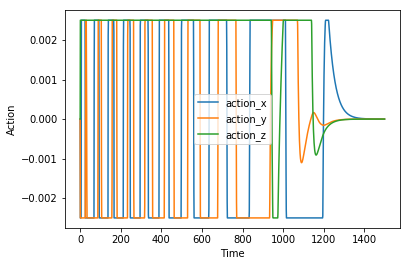

In [7]:
plt.plot(a_actual)
plt.ylabel('Action')
plt.xlabel('Time')
plt.legend(('action_x', 'action_y', 'action_z'))

No handles with labels found to put in legend.


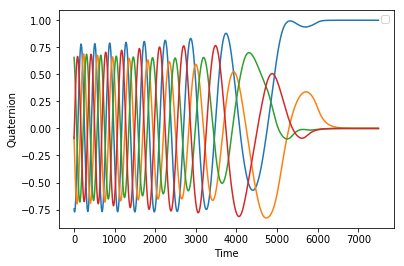

In [8]:
plt.ylabel('Quaternion')
plt.xlabel('Time')
plt.legend()
plt.plot(time,s[:,0:4], label='x')

No handles with labels found to put in legend.


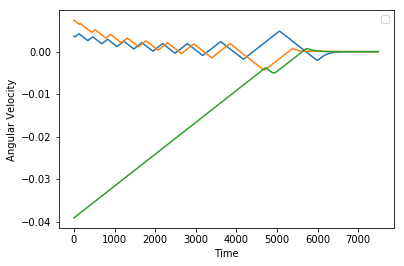

In [9]:
plt.ylabel('Angular Velocity')
plt.xlabel('Time')
plt.legend()
plt.plot(time,s[:,4:], label='x')

## PPO testing (Using PPO written for HW 6, with Mujoco Environment)

This notebook has results for 200 episodes, with polots every 100 episodes. 

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Ep 0	Moving average score: -5.90, Current score : 1.00	


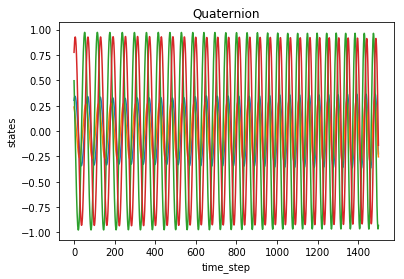

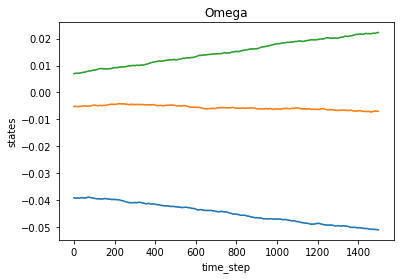

Ep 50	Moving average score: 0.96, Current score : 1.00	
Ep 100	Moving average score: 1.00, Current score : 1.00	


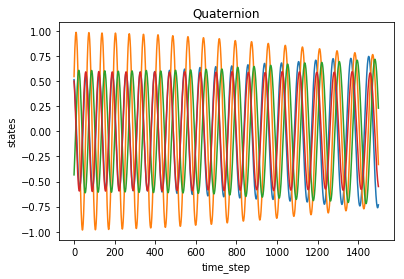

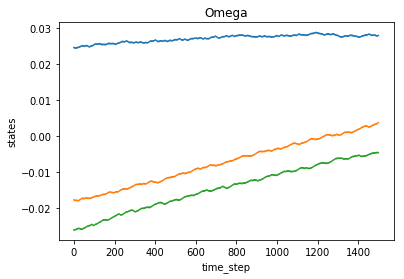

Ep 150	Moving average score: 1.00, Current score : 1.00	
Ep 200	Moving average score: 1.00, Current score : 1.00	


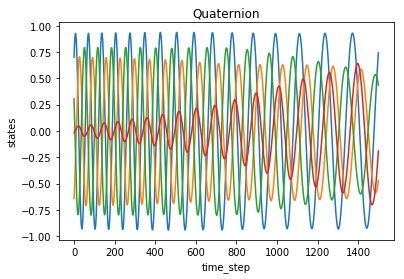

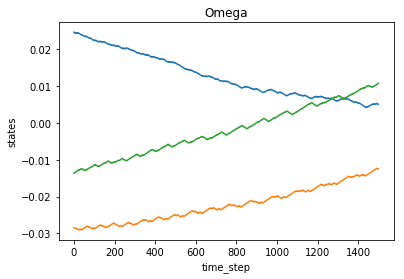

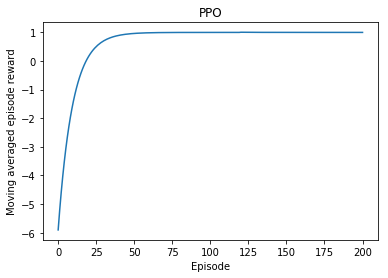

In [10]:
# %load PPO_attitudeDynamics_mujoco.py
"""
Created on Thu Sep  6 02:14:59 2018

@author: Vedant
"""
#from joblib import Parallel, delayed
import gym,sys
import sat_mujocoenv
import numpy as np

from collections import namedtuple
import multiprocessing
num_cores = multiprocessing.cpu_count()
import matplotlib.pyplot as plt
import numpy as np
import sat_mujocoenv

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import sys

gamma=0.999
seed=0
render=False
log_interval=100 #turned off logging, used to plot results while code runs instead
torch.manual_seed(seed)

TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'a_log_p', 'r', 's_'])
torch.set_default_tensor_type('torch.DoubleTensor')
inner_neuron = 100
class ActorCriticNet(nn.Module):


    def __init__(self):
        super(ActorCriticNet, self).__init__()
        self.fc1 = nn.Linear(7, inner_neuron)
        self.fc2 = nn.Linear(inner_neuron, inner_neuron)
        self.fc3 = nn.Linear(inner_neuron, inner_neuron)
        self.fc4 = nn.Linear(inner_neuron, inner_neuron)
        self.fc5 = nn.Linear(inner_neuron, inner_neuron)
        self.mu_head = nn.Linear(inner_neuron, 3)
        self.sigma_head = nn.Linear(inner_neuron, 3)
        self.v_head = nn.Linear(inner_neuron, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #if (inner_neuron>=10):
        #    x = F.dropout(self.fc1(x),0.2)
        x = F.relu(self.fc2(x))
        #if (inner_neuron>=10):
        #    x = F.dropout(self.fc2(x),0.2)
        x = F.relu(self.fc3(x))
        #if (inner_neuron>=10):
        #    x = F.dropout(self.fc3(x),0.2)
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        mu = 2.0* (torch.tanh(self.mu_head(x)))
        sigma = F.softplus(self.sigma_head(x))
        state_value = self.v_head(x)
        return (mu, (sigma+1e-10),state_value)


class Agent():

    clip_param = 0.1
    max_grad_norm = 0.5
    ppo_epoch = 100
    buffer_capacity, batch_size = 5000, 500

    def __init__(self):
        self.training_step = 0
        #self.anet = ActorNet().float()
        #self.cnet = CriticNet().float()
        self.acnet = ActorCriticNet().float()
        self.buffer = []
        self.counter = 0

        #self.optimizer_a = optim.Adam(self.anet.parameters(), lr=1e-4)
        #self.optimizer_c = optim.Adam(self.cnet.parameters(), lr=3e-4)
        self.optimizer_ac = optim.Adam(self.acnet.parameters(), lr=1e-4)

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            (mu, sigma,_) = self.acnet(state)
        dist = Normal(mu, sigma)
        action = dist.sample()
        action_log_prob = dist.log_prob(action)
        #action.clamp(-2.0, 2.0)
        return action, action_log_prob

    def get_value(self, state):

        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            _,_,state_value = self.acnet(state)
        return state_value.item()

    def save_param(self):
        torch.save(self.acnet.state_dict(), 'ppo_anet_params.pkl')
        #torch.save(self.cnet.state_dict(), 'ppo_cnet_params.pkl')

    def store(self, transition):
        self.buffer.append(transition)
        self.counter += 1
        return self.counter % self.buffer_capacity == 0

    def update(self):
        self.training_step += 1

        s = torch.tensor([t.s for t in self.buffer], dtype=torch.float)
        a = torch.tensor([t.a for t in self.buffer], dtype=torch.float)
        r = torch.tensor([t.r for t in self.buffer], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in self.buffer], dtype=torch.float)

        old_action_log_probs = torch.tensor(
            [t.a_log_p for t in self.buffer], dtype=torch.float)

        r = (r - r.mean()) / (r.std() + 1e-10)
        #print('R.std : ',r.std())
        with torch.no_grad():
            _,_,temp3 = self.acnet(s_)
            target_v = r + gamma * temp3

        _,_,temp = self.acnet(s) 
        adv = (target_v - temp).detach()
        #print('Adv : ',adv)

        for _ in range(self.ppo_epoch):
            for index in BatchSampler(
                    SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, False):

                (mu, sigma,_) = self.acnet(s[index])
                
                #sigma = torch.clamp(sigma, min=1e-5, max=10)
                dist = Normal(mu, sigma)
                #print('mu: ',mu, ' sigma: ',sigma)
                action_log_probs = dist.log_prob(a[index])
                #print('action_log_probs: ',action_log_probs)
                ratio = torch.exp(action_log_probs - old_action_log_probs[index])
                #print('Ratio: ', ratio)
                if np.isnan(action_log_probs.detach().numpy()).any():
                    print('mu NAN!')
                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param,
                                    1.0 + self.clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()
                _,_,temp2 = self.acnet(s[index])
                value_loss = F.smooth_l1_loss(temp2, target_v[index])
                ac_loss = action_loss+value_loss
                #print('AC loss : ',ac_loss)
                self.optimizer_ac.zero_grad()
                ac_loss.backward()
                nn.utils.clip_grad_norm_(self.acnet.parameters(), self.max_grad_norm)
                self.optimizer_ac.step()
                '''
                self.optimizer_a.zero_grad()
                action_loss.backward()
                nn.utils.clip_grad_norm_(self.anet.parameters(), self.max_grad_norm)
                self.optimizer_a.step()

                self.optimizer_c.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(self.cnet.parameters(), self.max_grad_norm)
                self.optimizer_c.step()
                '''

        del self.buffer[:]


def main():
    #env = gym.make('Pendulum-v0')
    #env = gym.make('attitudeDynamics-v0')
    #env.seed(seed)
    

    horizon = 1500 #steps
    maxabs_torque=2.50e-3
    dt = 5
    target_state = np.array([1,0,0,0,0,0,0]) # [q_0,q_1,q_2,q_3,w_0,w_1,w_2]
    w_mag = 4e-2
    w_tumble = 4e-1
    Noise = None
    render = False
    
    env = sat_mujocoenv.Sat_mujocoEnv(horizon,maxabs_torque, dt ,
                         target_state , w_mag  ,
                         w_tumble , Noise ,render )
    
    end = 0
    render = 0
    agent = Agent()
    last_state = []
    training_records = []
    running_reward = -10000
    state = env.reset()
    for i_ep in range(201):
        score = 0
        
        state = env.reset()
        nanerror = 1
        STA_q = []
        STA_w = []
        
        for t in range(1500):
            
            action, action_log_prob = agent.select_action(state)
            state_, reward, done,_ = env.step(action.numpy()[0])
            if render:
                env.render()
            if agent.store(Transition(state, action[0].tolist(), action_log_prob[0].tolist(), (reward + 1/8), state_)):
                agent.update()
            score += reward
            state = state_
            STA_q.append(state[0:4])
            STA_w.append(state[4:7])
            

        running_reward = running_reward * 0.9 + score * 0.1
        training_records.append(TrainingRecord(i_ep, running_reward))

        if i_ep % (log_interval/(2)) == 0:
            print('Ep {}\tMoving average score: {:.2f}, Current score : {:.2f}\t'.format(i_ep, running_reward/1500,score/1500))
        if i_ep % (log_interval) == 0:
            plt.plot(np.array(STA_q))
            plt.title('Quaternion')
            plt.xlabel('time_step')
            plt.ylabel('states')
            plt.show()
            #plt.savefig("img/ppo.png")
            plt.plot(np.array(STA_w))
            plt.title('Omega')
            plt.xlabel('time_step')
            plt.ylabel('states')
            #plt.savefig("img/ppo.png")
            plt.show()
                    #print("Solved! Moving average score is now {}!".format(running_reward))
            #render = 1
        if running_reward >1e4:
            end = 1
        if end:    
            #env.close()
            break
            
    #save_param()
    if nanerror == 0:
        agent.save_param()
    plt.plot([r.ep for r in training_records], [(r.reward/1500) for r in training_records])
    plt.title('PPO')
    plt.xlabel('Episode')
    plt.ylabel('Moving averaged episode reward')
    #plt.savefig("img/ppo.png")
    plt.show()

main()

## PPO training (Using PPO provided  HW 6 - example, with Mujoco Environment,with Mujoco Environment)

Details of all runs are saved under the "runs" directory (open with Tensorboard). The last run in the directory is the one shown below.

In [11]:
env = sat_mujocoenv.Sat_mujocoEnv(horizon,maxabs_torque,dt,target_state, w_mag ,w_tumble, Noise,render)
agent = ppo.PPOAgent(env)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [12]:
gamma = 0.999
lamb = 0.95
number_of_actors = 10
number_of_iterations = 200
number_of_epochs = 100
minibatch_size = 500
logstd_initial = -1 #-0.7
logstd_final = -2 # -1.6
epsilon = 0.2
use_multiprocess = False
res = agent.train(
    'Sat',
    gamma,
    lamb,
    number_of_actors,
    number_of_iterations,
    horizon,
    number_of_epochs,
    minibatch_size,
    logstd_initial,
    logstd_final,
    epsilon,
    use_multiprocess,
)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

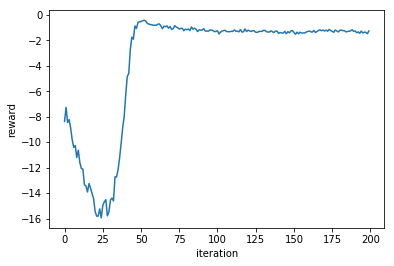

In [13]:
plt.plot(res['rewards'])
plt.xlabel('iteration')
plt.ylabel('reward');
#plt.xlim([1,-1000])

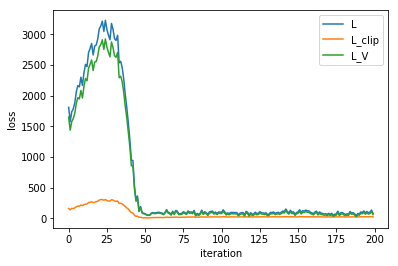

In [14]:
plt.plot(res['losses'], label='L')
plt.plot(res['losses_clip'], label='L_clip')
plt.plot(res['losses_V'], label='L_V')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend();

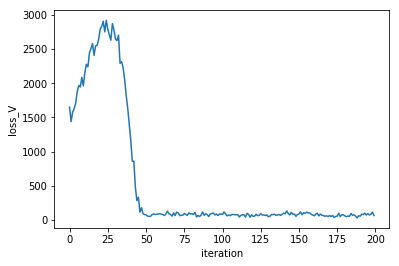

In [15]:
plt.plot(res['losses_V'], label='L_V')
plt.xlabel('iteration')
plt.ylabel('loss_V');

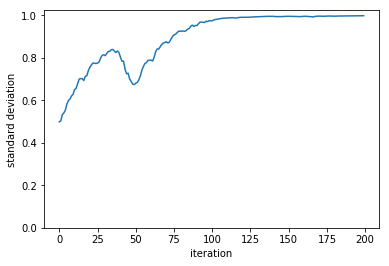

In [16]:
plt.plot(res['stds'])
plt.xlabel('iteration')
plt.gca().set_ylim(bottom=0)
plt.ylabel('standard deviation');

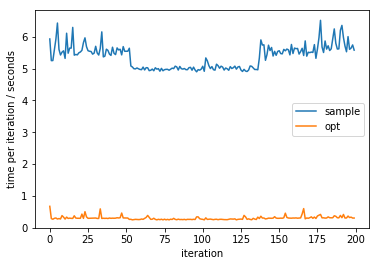

In [17]:
plt.plot(res['times_sample'], label='sample')
plt.plot(res['times_opt'], label='opt')
plt.gca().set_ylim(bottom=0)
plt.legend();
plt.xlabel('iteration')
plt.ylabel('time per iteration / seconds');

## Satellite simulation with agent

In [18]:
env = sat_mujocoenv.Sat_mujocoEnv(horizon,maxabs_torque,dt,target_state, w_mag ,w_tumble, Noise,render)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [24]:
T = horizon
#T = 2000
env.reset()
s = np.zeros((T, env.observation_dim))
r = np.zeros(T)
a = np.zeros((T, env.action_dim))
time = np.zeros(T)
s[0,:] = env.x
for t in range(1,T):
    a[t] = agent.action_greedy(s[t-1,:])
    s[t,:], r[t], _ , _ = env.step(a[t])
    a_actual[t] = env.a
    time[t] = (t - 1) * env.dt

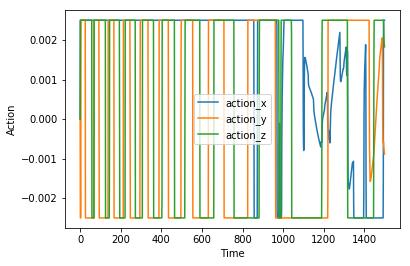

In [25]:
plt.plot(a_actual)
plt.ylabel('Action')
plt.xlabel('Time')
plt.legend(('action_x', 'action_y', 'action_z'))

average reward per step = 1.214824781383582


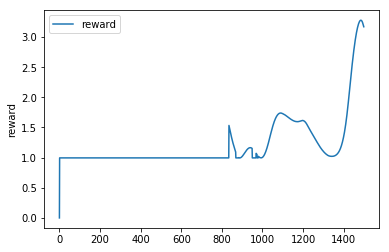

In [26]:
plt.plot(r, label='reward')
plt.ylabel('reward')
plt.legend()
print(f'average reward per step = {np.mean(r)}')

plt.ylabel('Quaternion')
plt.legend()
plt.plot(s[:,0:4], label='x')

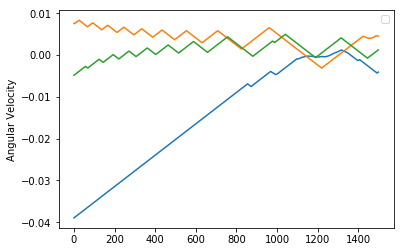

In [27]:
plt.ylabel('Angular Velocity')
plt.legend()
plt.plot(s[:,4:], label='x')

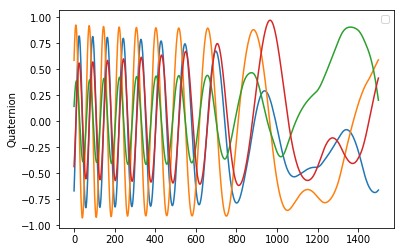

In [28]:
plt.ylabel('Quaternion')
plt.legend()
plt.plot(s[:,0:4], label='x')

In [29]:
for p in agent.net.parameters():
    print(p)

Parameter containing:
tensor([[-0.1225,  0.2677,  0.1015,  0.0006,  1.0600,  0.4695,  1.9161],
        [-0.2805, -0.0276,  0.0880,  0.0080, -1.9493, -2.3448,  2.0648],
        [-0.2617, -0.1930,  0.3259, -0.0375, -1.1249,  1.2662, -1.2405],
        [-0.0885,  0.2918, -0.1416, -0.4342,  0.4791, -0.1045,  3.2023],
        [-0.3477, -0.0055,  0.1169,  0.1672,  0.9764,  2.0166, -1.4453],
        [-0.1667, -0.0471, -0.0589,  0.1245, -3.3368,  0.3124, -3.1072],
        [-0.2440, -0.0102, -0.1967,  0.1630,  1.7255,  0.7713, -0.3344],
        [-0.3721, -0.1683,  0.3777,  0.2307,  1.5246,  1.7896,  0.5175],
        [ 0.2801,  0.0846,  0.2631, -0.0023,  1.1451, -0.7314,  1.7849],
        [-0.1626, -0.1026, -0.2293, -0.3590,  1.5955, -1.3121, -1.3659],
        [ 0.0271,  0.0025,  0.0142,  0.0399,  1.3633, -3.5977,  0.2313],
        [ 0.3871, -0.1196,  0.2117,  0.3209,  0.2492,  1.5325,  1.6569],
        [ 0.0296,  0.0301,  0.0605, -0.0188, -4.3502,  0.9039,  1.9373],
        [ 0.0006, -0.2347,  0

## Training with Stable Baselines PPO

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Done Training!
It took :  696.2164213657379  secs


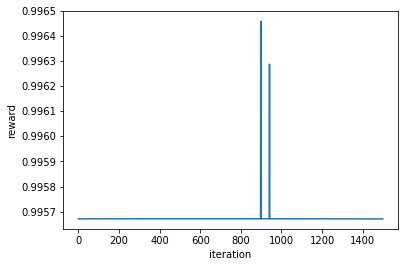

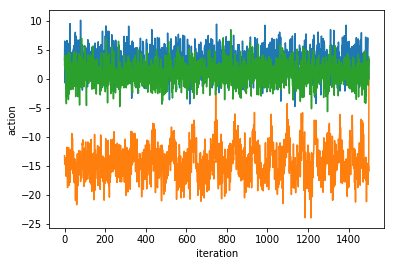

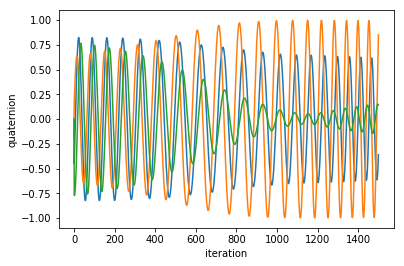

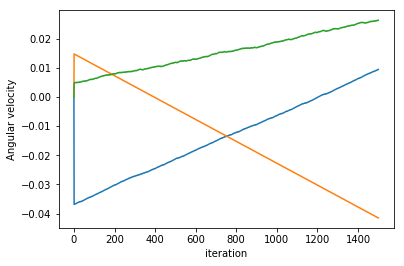

In [30]:
# %load stable_baselines_test.py
"""
Created on Mon Dec 10 21:23:02 2018

@author: vedant2
"""

import sat_mujocoenv

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2 as algorithm

import numpy as np
import matplotlib.pyplot as plt
import time

a = time.time()
horizon = 1500 #steps
maxabs_torque=2.50e-3
dt = 5
target_state = np.array([1,0,0,0,0,0,0]) # [q_0,q_1,q_2,q_3,w_0,w_1,w_2]
w_mag = 4e-2
w_tumble = 1e-1
Noise = None
render = False

env = sat_mujocoenv.Sat_mujocoEnv(horizon,maxabs_torque, dt ,
                     target_state , w_mag  ,
                     w_tumble , Noise ,render )
env = DummyVecEnv([lambda: env])  # The algorithms require a vectorized environment to run

model = algorithm(MlpPolicy, env, verbose=0)
model.learn(total_timesteps=1000000)
b = time.time()
print("Done Training!")
print('It took : ', b-a,' secs')
Final_run_nstep = 1500
rewards = np.ones([Final_run_nstep])
obs_list = np.zeros([Final_run_nstep+1,env.envs[0].observation_dim])
action_list = np.zeros([Final_run_nstep+1,env.envs[0].action_dim])

obs = env.reset()
for i in range(Final_run_nstep):
    action, _states = model.predict(obs)
    obs, rewards[i], dones, info = env.step(action)
    obs_list[i+1] = obs
    action_list[i] = action
    
    #print(rewards[i])



plt.plot(rewards)
plt.xlabel('iteration')
plt.ylabel('reward');
plt.show()

plt.plot(action_list)
plt.xlabel('iteration')
plt.ylabel('action');
plt.show()

plt.plot(obs_list[:,1:4])
plt.xlabel('iteration')
plt.ylabel('quaternion');
plt.show()

plt.plot(obs_list[:,4:])
plt.xlabel('iteration')
plt.ylabel('Angular velocity');
plt.show()
